In [5]:
# === Core scientific libraries ===
import numpy as np
import pandas as pd

# === Visualization ===
import matplotlib.pyplot as plt
import seaborn as sns

# === Scipy (scientific functions) ===
from scipy import stats
from scipy.stats import norm, expon
from scipy.special import expit

# === Statsmodels (econometrics / statistical modeling) ===
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.api import OLS

# === Scikit-learn: preprocessing ===
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# === Scikit-learn: models (supervised learning) ===
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LassoCV, LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from xgboost import XGBClassifier, XGBRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C

# === Scikit-learn: model selection & evaluation ===
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.base import clone
from sklearn.utils import resample

# === Causal inference (DoubleML) ===
import doubleml as dml
from doubleml import DoubleMLData, DoubleMLPLR

# === Other machine learning libraries ===
import GPy

# === Parallelization ===
from joblib import Parallel, delayed

# === Utilities ===
import itertools


In [6]:
# Assigning the current directory to this_dir
from pathlib import Path
this_dir = Path (".")

# make it absolute
print(this_dir.resolve())

C:\Users\Anna\master_thesis\master_thesis


## Data Creation

Now I will collect data files, correct them with the list of selected countries* and make long format to make it more convenient for Machine Learning.

*These countries mostly have no NA values in all datasets.   
Nevertheless, there were some correction for Ireland:

In dataset related to municipal waste per capita:
- The average was taken for 2015
- Total municipal wastes for 2 last years were taken from here https://www.cso.ie/en/releasesandpublications/ep/p-eii/environmentalindicatorsireland2023/waste/#:~:text=Municipal%20waste%20generated%20in%20Ireland%20was%203.2%20million%20tonnes%20in,kilogrammes%20per%20capita%20in%202021 and waste per capita was calculated depending on Ireland population.

For Serbia data for environment tax revenue as % of GDP was taken from https://data.stat.gov.rs/Home/Result/2503030203?languageCode=en-US.


In [7]:
selected_countries = ["Belgium", "Austria", "Czechia", "Ireland", "Cyprus", "Hungary", "Serbia", "Switzerland", 
                       "Sweden", "France", "Spain", "Netherlands", "Norway", "Germany", "Italy",
                       "Poland", "Lithuania", "Luxembourg", "Portugal", "Latvia", "Malta", 
                       "Slovenia", "Estonia", "Croatia", "Greece"]

### Policy

In my previous work, I focused only on the general attitudes of countries towards migration based on their stance on The Global Compact for Safe, Orderly and Regular Migration (GCM), an intergovernmentally negotiated agreement that countries either signed or did not sign in 2018. Now, I am also using MIPEX (Migrant Integration Policy Index). The policy areas of integration covered by the MIPEX are the following: Labour market mobility; Family reunification; Education; Political participation; Permanent residence; Access to nationality; Anti-discrimination; and Health. 

If a country has a high MIPEX score (60-100), I assign a value of 1 for the period after 2018. If the score is low (0-40), I assign a 0. If the MIPEX score is between 41 and 59 ("halfway favourable"), I use the country's position on the GCM, as well as its overall migration policy and recently laws referred to migration, to assign either a 0 or a 1. As a result, some countries were reclassified.

Values of Index were taken from MIPEX official website https://www.mipex.eu/key-findings, taking into consideration change of it during years, to understand the overall trend.

In [8]:
data_file_p = this_dir / "data" / "policy_upd.xlsx"
data_file_p.resolve()
df_policy = pd.read_excel(data_file_p, sheet_name="Sheet1")

from help_func import convert_to_long_format
# Converting into long format
df_policy_long = convert_to_long_format(df_policy, 
                                        id_vars=['Country'], 
                                        var_name='Year', 
                                        value_name='Policy')

print(df_policy_long)

         Country  Year  Policy
0        Belgium  2014       0
1        Czechia  2014       0
2        Denmark  2014       0
3        Germany  2014       0
4        Estonia  2014       0
..           ...   ...     ...
256       Norway  2022       1
257  Switzerland  2022       0
258       Serbia  2022       0
259     Bulgaria  2022       0
260     Slovakia  2022       0

[261 rows x 3 columns]


In [9]:
data_dir = this_dir / "data"
obtained_data_dir = data_dir / "obtained_data"

latex_table_p = df_policy.to_latex(index=False)

# Direction to file where will be stored Latex-table
latex_output_file = obtained_data_dir / "policy_table.tex"

with open(latex_output_file, "w", encoding="utf-8") as f:
    f.write(latex_table_p)

### Municipal Wastes

Afterwards, I will move on to the data on municipal waste, which is measured in kilograms per capita.
Municipal waste refers to waste generated by households, as well as small businesses and institutions, that is collected by or on behalf of municipalities. It typically includes waste from residential areas, street cleaning, and similar sources.

*All used datasets below are taken form official web-site of Euro Union statistics: https://ec.europa.eu/eurostat/databrowser/explore/all/all_themes

In [10]:
data_file_w = this_dir / "data" / "env_waste_mun.xlsx"
data_file_w.resolve()
data_was = pd.read_excel(data_file_w, sheet_name="Sheet 1", na_values=':')
data_was = data_was.rename(columns={"TIME": "Country"})

In [11]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='pandas')

filtered_data_was = data_was[data_was["Country"].isin(selected_countries)]

from help_func import convert_to_long_format

filtered_data_was_long = convert_to_long_format(filtered_data_was, 
                                        id_vars=['Country'], 
                                        var_name='Year', 
                                        value_name='waste_per_cap')

print(filtered_data_was_long)

         Country  Year  waste_per_cap
0        Belgium  2013          436.0
1        Czechia  2013          307.0
2        Germany  2013          615.0
3        Estonia  2013          293.0
4        Ireland  2013            NaN
..           ...   ...            ...
245     Slovenia  2022          487.0
246       Sweden  2022          395.0
247       Norway  2022          768.0
248  Switzerland  2022          677.0
249       Serbia  2022          473.0

[250 rows x 3 columns]


 C:\Users\Anna\AppData\Local\Temp\ipykernel_13632\1444614643.py:7: UserWarning:Ignoring `palette` because no `hue` variable has been assigned.


<Figure size 1000x600 with 0 Axes>

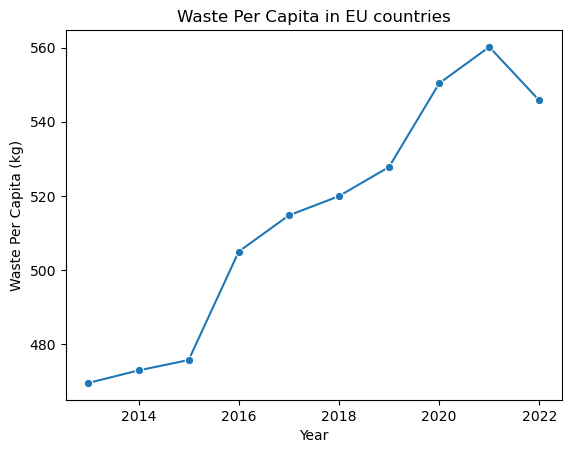

In [12]:
# Аggregation
avg_trends_waste = filtered_data_was_long.groupby(['Year'])['waste_per_cap'].mean().reset_index()

# Waste Per Capita
plt.figure(figsize=(10, 6))
fig, ax = plt.subplots()
sns.lineplot(data=avg_trends_waste, x='Year', y='waste_per_cap', 
             palette=["blue"], marker="o")

plt.title('Waste Per Capita in EU countries')
plt.ylabel('Waste Per Capita (kg)')
plt.xlabel('Year')
plt.show()

I will analyze this variable in more detail, so we need data for all years from 2013 to 2022 (later, due to the limitations of some datasets, data from 2015 to 2022 will be used). I will start with analysis unexpected outliers in waste growth for any given year.

<Axes: xlabel='Year'>

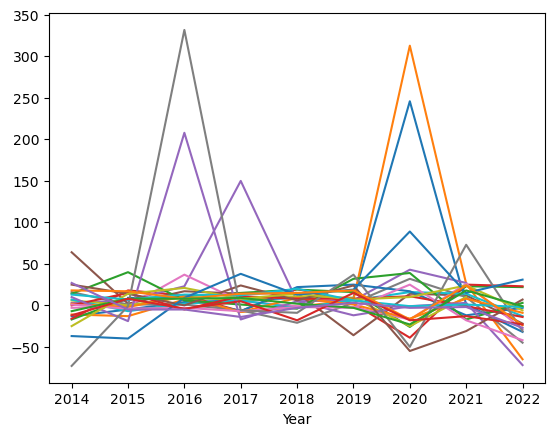

In [13]:
plottable = filtered_data_was_long.pivot(columns=['Country'], index='Year')
diff = plottable.diff()
diff.plot(legend=False)

This graph shows waste change YoY per country. As we can see there are 4 extremely high surges for 4 different countries that translate to the step changes in the waste levels (see graph below). The most appropriate explanation is that for these countries methodology for waste accounting was changed, because, first, the change is **too abrupt and massive** (25-30% in a year) to be caused by a natural non-catastrophic course of events; second, after the step change the graph **resumes its general pattern** of behavior, albeit at a higher base level; third, in each case, **none of neighboring countries see changes** in waste levels of a comparable magnitude.

Now I will find which countries they are.

<Axes: xlabel='Year'>

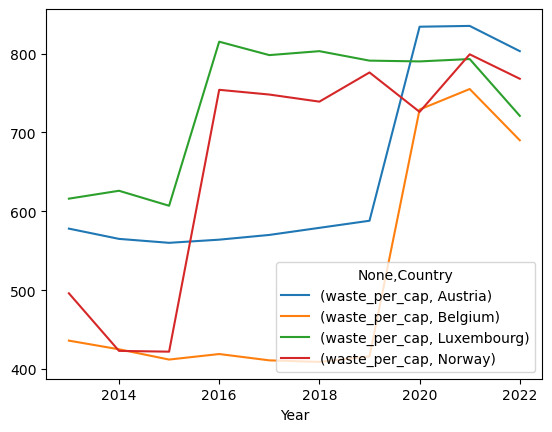

In [14]:
plottable.loc[:, diff.max() > 200].plot()

In [15]:
# repair waste data for Austria, Belgium, Norway, Luxembourg before the following years:
repairs = [('Austria', 2020), ('Belgium', 2020), ('Norway', 2016), ('Luxembourg', 2016)] 

The most sensible option to deal with these countries' data  is to leave only more recent data points, for which the new, presumably corrected methodology was used.

In [16]:
# Leave only more recent data (with higher levels) asuming it was collected with improved methodology

fdwl = filtered_data_was_long
for country, first_correct_yr in repairs:
    fdwl.drop(fdwl[(fdwl.Country == country) & (fdwl.Year < first_correct_yr)].index, inplace=True)

# Ensure, for example, that Austria lost all years before 2020 
filtered_data_was_long[filtered_data_was_long.Country == 'Austria']

,Country,Year,waste_per_cap
192,Austria,2020,834.0
217,Austria,2021,835.0
242,Austria,2022,803.0


<Axes: xlabel='Year'>

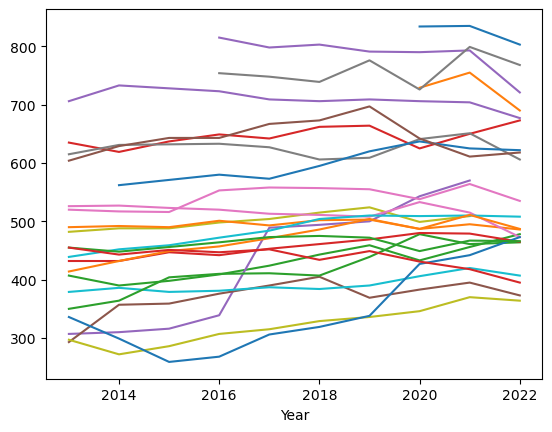

In [17]:
filtered_data_was_long.pivot(columns=['Country'], index='Year').plot(legend=False)

### Covariates

Let's gather data for the covariates   

#### Environmental Taxes

In [18]:
data_file_t = this_dir / "data" / "env_tax_gdp_per.xlsx"
data_file_t.resolve()
data_etax = pd.read_excel(data_file_t, sheet_name="Sheet 1")
data_etax = data_etax.rename(columns={"TIME": "Country"})

filtered_data_etax = data_etax[data_etax["Country"].isin(selected_countries)]

In [19]:
from help_func import convert_to_long_format
# Converting into long format
filtered_data_etax_long = convert_to_long_format(filtered_data_etax, 
                                        id_vars=['Country'], 
                                        var_name='Year', 
                                        value_name='env_tax')
print(filtered_data_etax_long)

         Country  Year env_tax
0        Belgium  2014    2.54
1        Czechia  2014    2.12
2        Germany  2014    1.99
3        Estonia  2014    2.66
4        Ireland  2014     2.4
..           ...   ...     ...
220     Slovenia  2022    2.87
221       Sweden  2022    1.91
222       Norway  2022    1.29
223  Switzerland  2022    1.27
224       Serbia  2022     3.4

[225 rows x 3 columns]


#### Unemployment

In [20]:
data_file_u = this_dir / "data" / "unemp_percent.xlsx"
data_file_u.resolve()
data_unemp = pd.read_excel(data_file_u, sheet_name="Sheet 1")
data_unemp = data_unemp.rename(columns={"TIME": "Country"})

filtered_data_unemp = data_unemp[data_unemp["Country"].isin(selected_countries)]
filtered_data_unemp = filtered_data_unemp.drop(filtered_data_unemp.columns[1:2], axis=1)
filtered_data_unemp = filtered_data_unemp.drop(filtered_data_unemp.columns[-1], axis=1)


In [21]:
from help_func import convert_to_long_format
# Converting into long format
filtered_data_unemp_long = convert_to_long_format(filtered_data_unemp, 
                                        id_vars=['Country'], 
                                        var_name='Year', 
                                        value_name='unemp_rate')


print(filtered_data_unemp_long)

         Country  Year unemp_rate
0        Belgium  2015        8.7
1        Czechia  2015        5.1
2        Germany  2015        4.4
3        Estonia  2015        6.4
4        Ireland  2015        9.9
..           ...   ...        ...
195     Slovenia  2022          4
196       Sweden  2022        7.5
197       Norway  2022        3.2
198  Switzerland  2022        4.1
199       Serbia  2022        9.6

[200 rows x 3 columns]


#### Real Expenditures

In [22]:
data_file_e = this_dir / "data" / "real_exp_pc.xlsx"
data_file_e.resolve()
data_exp = pd.read_excel(data_file_e, sheet_name="Sheet 1")
data_exp = data_exp.rename(columns={"TIME": "Country"})

filtered_data_exp = data_exp[data_exp["Country"].isin(selected_countries)]
filtered_data_exp = filtered_data_exp.drop(filtered_data_exp.columns[-1], axis=1)


In [23]:
from help_func import convert_to_long_format
# Converting into long format
filtered_data_exp_long = convert_to_long_format(filtered_data_exp, 
                                        id_vars=['Country'], 
                                        var_name='Year', 
                                        value_name='rexp_per_cap')

print(filtered_data_exp_long)

         Country  Year rexp_per_cap
0        Belgium  2014        21300
1        Czechia  2014        14500
2        Germany  2014        22500
3        Estonia  2014        12700
4        Ireland  2014        17300
..           ...   ...          ...
220     Slovenia  2022        20200
221       Sweden  2022        26000
222       Norway  2022        29700
223  Switzerland  2022        27300
224       Serbia  2022        12300

[225 rows x 3 columns]


#### Urbanization

In [24]:
data_file_ur = this_dir / "data" / "p_urbanization.xlsx"
data_file_ur.resolve()
data_urb = pd.read_excel(data_file_ur, sheet_name="Data")
data_urb = data_urb.rename(columns={"TIME": "Country"})

filtered_data_urb = data_urb[data_urb["Country"].isin(selected_countries)]


In [25]:
from help_func import convert_to_long_format
# Converting into long format
filtered_data_urb_long = convert_to_long_format(filtered_data_urb, 
                                        id_vars=['Country'], 
                                        var_name='Year', 
                                        value_name='urb_ind')

print(filtered_data_urb_long)

         Country  Year  urb_ind
0        Belgium  2014   97.833
1        Germany  2014   77.190
2        Estonia  2014   68.269
3         Sweden  2014   86.247
4          Spain  2014   79.366
..           ...   ...      ...
220      Hungary  2022   72.552
221       Serbia  2022   56.873
222  Switzerland  2022   74.092
223       Norway  2022   83.664
224       Greece  2022   80.357

[225 rows x 3 columns]


### Merging

In [26]:
# Merging tables on the columns 'Country' and 'Year'
df_combined1 = pd.merge(filtered_data_was_long, df_policy_long,
                       on=['Country', 'Year'], how='inner')

# Adding other covariates in a similar way
df_combined2 = pd.merge(df_combined1, filtered_data_etax_long, on=['Country', 'Year'], how='inner')
df_combined3 = pd.merge(df_combined2, filtered_data_unemp_long, on=['Country', 'Year'], how='inner')
df_combined4 = pd.merge(df_combined3, filtered_data_exp_long, on=['Country', 'Year'], how='inner')
df = pd.merge(df_combined4, filtered_data_urb_long, on=['Country', 'Year'], how='inner')

df['waste_per_cap'] = pd.to_numeric(df['waste_per_cap'], errors='coerce')

print(df)

         Country  Year  waste_per_cap  Policy env_tax unemp_rate rexp_per_cap  \
0        Czechia  2015          316.0       0    2.05        5.1        14800   
1        Germany  2015          632.0       0    1.92        4.4        22800   
2        Estonia  2015          359.0       0    2.73        6.4        13300   
3        Ireland  2015          571.0       0    1.89        9.9        17800   
4         Greece  2015          488.0       0     4.2         25        14600   
..           ...   ...            ...     ...     ...        ...          ...   
183     Slovenia  2022          487.0       1    2.87          4        20200   
184       Sweden  2022          395.0       1    1.91        7.5        26000   
185       Norway  2022          768.0       1    1.29        3.2        29700   
186  Switzerland  2022          677.0       0    1.27        4.1        27300   
187       Serbia  2022          473.0       0     3.4        9.6        12300   

     urb_ind  
0     73.477

In [27]:
# Create feature 'Group': 1 if a country has ever adopted 'Policy' , 0 - never adopted 'Policy' 
new_cols = list(df.columns)
new_cols.insert(4, 'Group')
policy_per_country = df.groupby('Country')['Policy'].max()
df['Group'] = df['Country'].map(policy_per_country)
df = df[new_cols]

In [28]:
# Preview example of df
df[df.Country.isin(['Croatia', 'Denmark'])]

,Country,Year,waste_per_cap,Policy,Group,env_tax,unemp_rate,rexp_per_cap,urb_ind
7,Croatia,2015,398.0,0,0,4.21,16.2,11600,56.155
28,Croatia,2016,409.0,0,0,4.31,13,12100,56.403
51,Croatia,2017,424.0,0,0,4.33,11.1,12700,56.667
74,Croatia,2018,443.0,0,0,4.36,8.3,13300,56.947
97,Croatia,2019,459.0,0,0,4.24,6.6,13900,57.242
121,Croatia,2020,433.0,0,0,4.07,7.4,13600,57.553
146,Croatia,2021,456.0,0,0,3.86,7.5,15500,57.878
171,Croatia,2022,478.0,0,0,3.34,6.8,17600,58.219


In [29]:
data_dir = this_dir / "data"
obtained_data_dir = data_dir / "obtained_data"
output_file = obtained_data_dir / "original_data.xlsx"
df.to_excel(output_file, index=False)

In [30]:
df_preview = pd.concat([df.head(5), df.tail(5)])

latex_table_all = df_preview.to_latex(index=False)

latex_output_file_1 = obtained_data_dir / "f_table.tex"

with open(latex_output_file_1, "w", encoding="utf-8") as f:
    f.write(latex_table_all)

## Data Analysis and Preprocessing

Let's visualize the general trend of the waste level for each country group: plot mean waste of those countries who adopted the Policy versus those who did not.

<Figure size 1000x600 with 0 Axes>

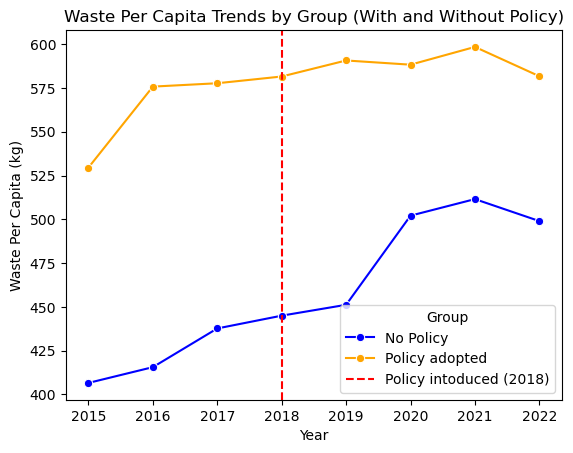

In [31]:
# Аggregation
avg_trends_waste = df.groupby(['Year', 'Group'])['waste_per_cap'].mean().reset_index()

# Waste Per Capita
plt.figure(figsize=(10, 6))
fig, ax = plt.subplots()
sns.lineplot(data=avg_trends_waste, x='Year', y='waste_per_cap', hue='Group', 
             palette=["blue", "orange"], marker="o")

plt.axvline(2018, color='red', linestyle='--', label='Policy intoduced (2018)')
plt.title('Waste Per Capita Trends by Group (With and Without Policy)')
plt.ylabel('Waste Per Capita (kg)')
plt.xlabel('Year')
handles, labels = ax.get_legend_handles_labels()
labels[0] = 'No Policy'
labels[1] = 'Policy adopted'
plt.legend(title='Group', handles=handles, labels=labels)
plt.show()

As before I am assuming that each country's decision is based on their general migration policy which is stay the same from the begininng. 
I will consider problem related to finding ATE of having such type of Policy during several years.

*NB. The adoption of the policy does not lead to an impact, as these changes will not show the effect within our short observation period. The fact that the policy exists classifies a country into a certain group.*

Also, despite having years, we are not considering time dependency and do not use years as a factor/time variable. We do not consider the change of waste generation (we look at the absolute value), and we do not care how the amount of waste has changed compared to the previous year; each value does not depend on the previous one (which is the definition of time dependency), meaning the process is stationary. 

*NB. Year as a factor does not have impact which was checked for the interest later.*

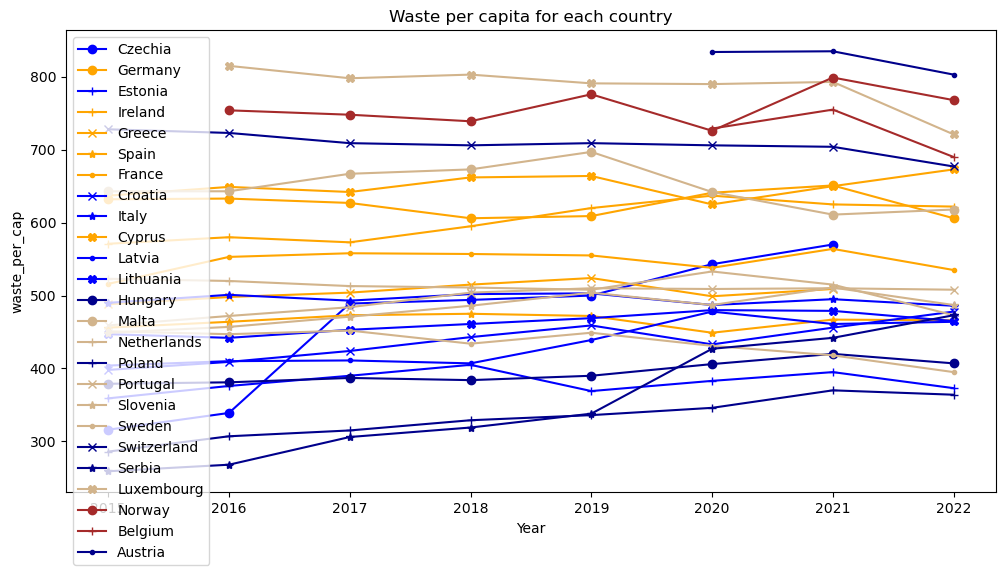

In [32]:
# Graph of waste per year for each country

countries = df["Country"].unique()
plt.figure(figsize=(12, 6))

policy_colors_markers = itertools.cycle(itertools.product(('orange', 'tan', 'brown'), ('o', '+', 'x', '*', '.', 'X')))
no_policy_colors_markers = itertools.cycle(itertools.product(('blue', 'darkblue', 'cornflowerblue'), ('o', '+', 'x', '*', '.', 'X')))

y = 'waste_per_cap'
x = 'Year'
for country in countries:
    subset = df[df["Country"] == country]
    #color = "orange" if subset["Policy"].iloc[0] == 1 else "blue" 
    if  subset["Group"].iloc[0] == 1:
        color, marker = next(policy_colors_markers)
    else:
        color, marker = next(no_policy_colors_markers)
    plt.plot(subset[x], subset[y], marker=marker, label=country, color=color)

plt.xlabel(x)
plt.ylabel(y)
plt.title("Waste per capita for each country")
plt.legend()
plt.show()

Before jumping in ML and DML parts it is needed to apply scaling (I chose MinMax Scaler): 

### MinMax Scaler Formula:

The MinMax Scaler is used to normalize or scale data within a specific range (between 0 and 1). The formula for MinMax scaling is:

$$ 
X_{scaled} = \frac{X - X_{min}}{X_{max} - X_{min}}
$$

In [33]:
df_n = df.copy() 

# Select columns to be standardized
columns_to_scale = ['env_tax', 'unemp_rate', 'rexp_per_cap', 'urb_ind']

# Keep non-standardized columns separately
other_columns = ['Country', 'Year', 'waste_per_cap', 'Policy', 'Group']

# Standardize only the selected columns
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_n[columns_to_scale])

# Convert the standardized data back to a DataFrame
to_scaled_df = pd.DataFrame(scaled_data, columns=columns_to_scale, index=df_n.index)

# Combine standardized and non-standardized columns
scaled_df = pd.concat([df_n[other_columns], to_scaled_df], axis=1)
scaled_df['waste_per_cap'] = pd.to_numeric(scaled_df['waste_per_cap'], errors='coerce')

scaled_df = scaled_df.dropna()
scaled_df 


,Country,Year,waste_per_cap,Policy,Group,env_tax,unemp_rate,rexp_per_cap,urb_ind
0,Czechia,2015,316.0,0,0,0.249471,0.134783,0.255411,0.443884
1,Germany,2015,632.0,0,1,0.221987,0.104348,0.601732,0.527788
2,Estonia,2015,359.0,0,0,0.393235,0.191304,0.190476,0.329825
3,Ireland,2015,571.0,0,1,0.215645,0.343478,0.385281,0.197354
4,Greece,2015,488.0,0,1,0.704017,1.000000,0.246753,0.546854
...,...,...,...,...,...,...,...,...,...
183,Slovenia,2022,487.0,1,1,0.422833,0.086957,0.489177,0.044397
184,Sweden,2022,395.0,1,1,0.219873,0.239130,0.740260,0.782273
185,Norway,2022,768.0,1,1,0.088795,0.052174,0.900433,0.673465
186,Switzerland,2022,677.0,0,0,0.084567,0.091304,0.796537,0.457744


In [34]:
data_dir = this_dir / "data"
obtained_data_dir = data_dir / "obtained_data"
output_file = obtained_data_dir / "original_data_policy_scaled.xlsx"
scaled_df.to_excel(output_file, index=False)

## ML Workflow

I will start with standard OLS regressions to first investigate whether a country's group affiliation affects waste generation overall. Then, I will analyze the impact of each covariate on waste per capita by running separate regressions for each group.

In [35]:
# Does Group influence waste?

ml_df = scaled_df

y = ml_df['waste_per_cap'] 
X_new = ml_df[['Group']]
X_new = sm.add_constant(X_new)
ols_model = sm.OLS(y, X_new).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:          waste_per_cap   R-squared:                       0.203
Model:                            OLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                     46.93
Date:                Wed, 27 Aug 2025   Prob (F-statistic):           1.07e-10
Time:                        15:13:54   Log-Likelihood:                -1150.3
No. Observations:                 186   AIC:                             2305.
Df Residuals:                     184   BIC:                             2311.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        459.7683     13.035     35.272      0.0

- The coefficient for Group = 119.41 means that belonging to Group 1 (Group = 1) increases municipal waste per capita by an average of 119.41 units compared to Group 0 (if Group = 0, the average waste level is 459.77).
- A p-value of 0.000 means that the probability of obtaining such a result by chance is almost 0. Using a significance level of α = 0.05 (5%), we reject the null hypothesis that Group has no effect on waste per capita.
- Since 0 is not included in this interval, the effect of Group is statistically significant.

In [36]:
# What parameters explain waste for countries without Policy
y = ml_df['waste_per_cap'] [ml_df.Group == 0]
X_new = ml_df[["unemp_rate" , 'env_tax', 'rexp_per_cap', 'urb_ind']] [ml_df.Group == 0]

# Add const
X_new = sm.add_constant(X_new)

# (OLS)
ols_model = sm.OLS(y, X_new).fit()

print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:          waste_per_cap   R-squared:                       0.692
Model:                            OLS   Adj. R-squared:                  0.676
Method:                 Least Squares   F-statistic:                     43.34
Date:                Wed, 27 Aug 2025   Prob (F-statistic):           5.34e-19
Time:                        15:13:54   Log-Likelihood:                -465.86
No. Observations:                  82   AIC:                             941.7
Df Residuals:                      77   BIC:                             953.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          251.9119     58.508      4.306   

In [37]:
# What parameters explain waste for countries with Policy
y = ml_df['waste_per_cap'] [ml_df.Group == 1]
X_new = ml_df[["unemp_rate" , 'env_tax', 'rexp_per_cap', 'urb_ind']] [ml_df.Group == 1]

# Add const
X_new = sm.add_constant(X_new)

# (OLS)
ols_model = sm.OLS(y, X_new).fit()

print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:          waste_per_cap   R-squared:                       0.342
Model:                            OLS   Adj. R-squared:                  0.315
Method:                 Least Squares   F-statistic:                     12.85
Date:                Wed, 27 Aug 2025   Prob (F-statistic):           1.84e-08
Time:                        15:13:55   Log-Likelihood:                -613.09
No. Observations:                 104   AIC:                             1236.
Df Residuals:                      99   BIC:                             1249.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          494.2422     49.364     10.012   

In [ ]:
import pandas as pd
import statsmodels.api as sm
import numpy as np

# Model for Group 0
y0 = ml_df['waste_per_cap'][ml_df.Group == 0]
X0 = ml_df[["unemp_rate", 'env_tax', 'rexp_per_cap', 'urb_ind']][ml_df.Group == 0]
X0 = sm.add_constant(X0)
ols_model_0 = sm.OLS(y0, X0).fit()

# Model for Group 1
y1 = ml_df['waste_per_cap'][ml_df.Group == 1]
X1 = ml_df[["unemp_rate", 'env_tax', 'rexp_per_cap', 'urb_ind']][ml_df.Group == 1]
X1 = sm.add_constant(X1)
ols_model_1 = sm.OLS(y1, X1).fit()

# Predict potential outcomes for ALL observations
X_all = ml_df[["unemp_rate", 'env_tax', 'rexp_per_cap', 'urb_ind']]
X_all = sm.add_constant(X_all)

# Outcome if everyone was in Group 1
y_pred_1 = ols_model_1.predict(X_all)

# Outcome if everyone was in Group 0
y_pred_0 = ols_model_0.predict(X_all)

# Individual Treatment Effect (ITE)
ite = y_pred_1 - y_pred_0

# Average Treatment Effect (ATE)
ate_or = np.mean(ite)

print(f"The ATE calculated using the Outcome Regression (OR) method is: {ate_or:.3f}")

The ATE calculated using the Outcome Regression (OR) method is: 44.399


## Propensity Score

In [39]:
b_df = ml_df.copy()

D = b_df['Group'].values

X = b_df.drop(columns=['Country', 'Year', 'waste_per_cap', 'Policy', 'Group'])

# Estimation propensity scores via LASSO logistic regression
model = LogisticRegressionCV(
    cv=10,
    penalty='l1',
    solver='liblinear',
    max_iter=1000,
    scoring='neg_log_loss'
)
model.fit(X, D)
# Predicted probabilities
ps_est = model.predict_proba(X)[:, 1]
# The intercept and coefficients
ps_coef_with_intercept = np.concatenate([model.intercept_.reshape(-1, 1), model.coef_.T], axis=0)

# Model coefficients
ps_coef = model.coef_

b_df['ps'] = ps_est


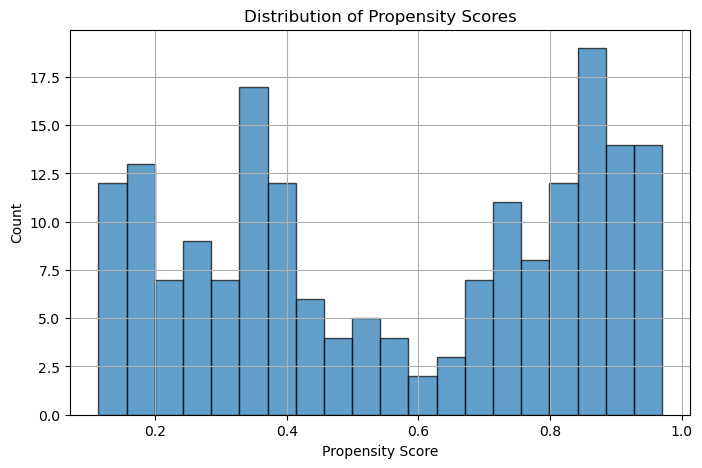

In [40]:
plt.figure(figsize=(8, 5))
plt.hist(b_df['ps'], bins=20, edgecolor='black', alpha=0.7)
plt.title('Distribution of Propensity Scores')
plt.xlabel('Propensity Score')
plt.ylabel('Count')
plt.grid(True)
plt.show()

In [41]:
def ps_trim(ps, t):
    return np.clip(ps, t, 1 - t)

def lhs(gam, ps):
    return gam * np.sum((1 / (ps * (1 - ps))) <= gam)

def rhs(gam, ps):
    mask = (1 / (ps * (1 - ps))) <= gam
    return 2 * np.sum((1 / (ps * (1 - ps)))[mask])

# Find the optimal value of alpha (t)
alpha_range = np.arange(0.01, 0.5, 0.001)
gamma_vals = 1 / (alpha_range * (1 - alpha_range))
diffs = [rhs(g, ps_est) - lhs(g, ps_est) for g in gamma_vals]

# Find the minimum value of alpha where the difference >= 0
valid_idx = np.where(np.array(diffs) >= 0)[0]
if len(valid_idx) > 0:
    gam_star = gamma_vals[valid_idx[0]]
    alp_star = 0.5 - np.sqrt(0.25 - 1 / gam_star)
    print(f"Optimal t according to Crump: {alp_star:.3f}")
else:
    print("Could not find the optimal t (possibly the PS distribution is too good)")


Optimal t according to Crump: 0.090


In [42]:
# Cut on Crump threshold (t = 0.09)
t_crump = 0.090

b_df_trimmed = b_df[(b_df['ps'] >= t_crump) & (b_df['ps'] <= 1 - t_crump)].copy()
print(f"Observations remained after trimming: {len(b_df_trimmed)} from {len(b_df)}")


Observations remained after trimming: 169 from 186


In [43]:
Y_data = b_df_trimmed['waste_per_cap'].values
D_data = b_df_trimmed['Group'].values
Z_data = b_df_trimmed.drop(columns=[
    'Country', 'Year', 'waste_per_cap', 'Policy', 'Group', 'ps'
]).values
ps_est_0 = b_df_trimmed['ps'].values

In [44]:
import scipy.io as sio
import numpy as np

output_dir = this_dir / "Replication" / "Data"

file_path = output_dir / "Real_ps_est.mat"

data_to_save = {
    "Y": Y_data.reshape(-1, 1),
    "D": D_data.reshape(-1, 1),
    "Z": Z_data,
    "ps_est": ps_est_0.reshape(-1, 1),
    "ps_coef": ps_coef_with_intercept,
}

sio.savemat(file_path, data_to_save)


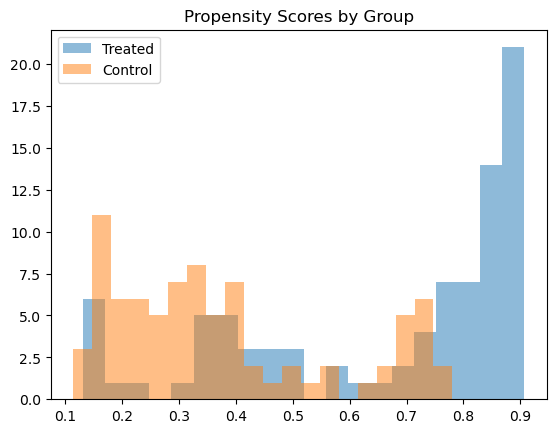

In [45]:
plt.hist(ps_est_0[D_data == 1], bins=20, alpha=0.5, label='Treated')
plt.hist(ps_est_0[D_data == 0], bins=20, alpha=0.5, label='Control')
plt.legend()
plt.title("Propensity Scores by Group")
plt.show()

In [46]:
print("Y treated avg:", Y_data[D_data == 1].mean())
print("Y control avg:", Y_data[D_data == 0].mean())

Y treated avg: 567.3333333333334
Y control avg: 459.7682926829268


In [47]:
# OLS after trimming

df = pd.DataFrame({'Y': Y_data, 'D': D_data})
model = smf.ols('Y ~ D', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     39.55
Date:                Wed, 27 Aug 2025   Prob (F-statistic):           2.70e-09
Time:                        15:13:55   Log-Likelihood:                -1034.9
No. Observations:                 169   AIC:                             2074.
Df Residuals:                     167   BIC:                             2080.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    459.7683     12.272     37.464      0.0

## Point estimators


## DML Workflow

This study examines the effect of Policy adoption on waste level based on a country's classification into one of the two groups. Therefore, the treatment variable is binary. Country specifics, such as policies, social, and economic conditions, vary across nations; these variations are likely to cause heterogeneity of the treatment effect. Therefore,  the most suitable DML model for this analysis is IRM (Binary Interactive Regression Model).

$$
\begin{aligned}
Y &= g_0(D, X) + U, & &\mathbb{E}(U | X, D) = 0, \\
D &= m_0(X) + V, & &\mathbb{E}(V | X) = 0.
\end{aligned}
$$

In [63]:
# IRM 
# learners: both Random Forest

ml_g = RandomForestRegressor(n_estimators=100, max_depth=5, min_samples_leaf=3)

ml_m = RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_leaf=3)

np.random.seed(42)

obj_dml_data = dml.DoubleMLData(b_df_trimmed, 'waste_per_cap', 'Group', x_cols = ['env_tax', 'rexp_per_cap', 'urb_ind', "unemp_rate"])

dml_irm_obj = dml.DoubleMLIRM(obj_dml_data, ml_g, ml_m, n_folds = 5)

print(dml_irm_obj.fit())

================== DoubleMLIRM Object ==================

------------------ Data summary      ------------------
Outcome variable: waste_per_cap
Treatment variable(s): ['Group']
Covariates: ['env_tax', 'rexp_per_cap', 'urb_ind', 'unemp_rate']
Instrument variable(s): None
No. Observations: 169

------------------ Score & algorithm ------------------
Score function: ATE

------------------ Machine learner   ------------------
Learner ml_g: RandomForestRegressor(max_depth=5, min_samples_leaf=3)
Learner ml_m: RandomForestClassifier(max_depth=5, min_samples_leaf=3)
Out-of-sample Performance:
Regression:
Learner ml_g0 RMSE: [[70.15517286]]
Learner ml_g1 RMSE: [[55.70428989]]
Classification:
Learner ml_m Log Loss: [[0.18650137]]

------------------ Resampling        ------------------
No. folds: 5
No. repeated sample splits: 1

------------------ Fit summary       ------------------
            coef    std err         t         P>|t|      2.5 %     97.5 %
Group  62.681168  10.510249  5.96381

In [62]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from doubleml import DoubleMLData, DoubleMLIRM
from sklearn.model_selection import KFold
import warnings

warnings.filterwarnings('ignore')

ml_g = RandomForestRegressor(n_estimators=200, max_depth=5, min_samples_leaf=2, random_state=42)
ml_m = RandomForestClassifier(n_estimators=200, max_depth=5, min_samples_leaf=2, random_state=42)

# The key difference: n_rep=5 and n_folds=5 to match the author's DML procedure
np.random.seed(123)
dml_obj = DoubleMLIRM(obj_dml_data, 
                      ml_g, 
                      ml_m, 
                      n_folds=5, 
                      n_rep=5) # This is the "DML2" procedure with 5 repetitions

dml_obj.fit()

print(dml_obj.summary)

            coef    std err         t         P>|t|      2.5 %     97.5 %
Group  67.103868  10.573429  6.346462  2.203229e-10  46.962195  87.202897


In [73]:
dml_ate_rf = dml_obj.summary.loc['Group', 'coef']
dml_std_rf = dml_obj.summary.loc['Group', 'std err']

In [69]:
# Lasso
lasso =  Lasso()
lasso_class = LogisticRegression()

# Initialize DoubleMLIRM model
np.random.seed(123)
dml_irm_lasso = dml.DoubleMLIRM(obj_dml_data,
                          ml_g=lasso,
                          ml_m=lasso_class, 
                          n_folds=5, 
                          n_rep=5)
print(dml_irm_lasso.fit())

================== DoubleMLIRM Object ==================

------------------ Data summary      ------------------
Outcome variable: waste_per_cap
Treatment variable(s): ['Group']
Covariates: ['env_tax', 'rexp_per_cap', 'urb_ind', 'unemp_rate']
Instrument variable(s): None
No. Observations: 169

------------------ Score & algorithm ------------------
Score function: ATE

------------------ Machine learner   ------------------
Learner ml_g: Lasso()
Learner ml_m: LogisticRegression()
Out-of-sample Performance:
Regression:
Learner ml_g0 RMSE: [[75.73780976]
 [74.11173753]
 [74.35041231]
 [75.73963589]
 [73.77669818]]
Learner ml_g1 RMSE: [[81.63591716]
 [81.4172957 ]
 [82.3700308 ]
 [83.31330183]
 [80.10569365]]
Classification:
Learner ml_m Log Loss: [[0.56645312]
 [0.56128364]
 [0.56218406]
 [0.56586053]
 [0.56878353]]

------------------ Resampling        ------------------
No. folds: 5
No. repeated sample splits: 5

------------------ Fit summary       ------------------
            coef

In [70]:
dml_ate_lasso = dml_irm_lasso.summary.loc['Group', 'coef']
dml_std_lasso = dml_irm_lasso.summary.loc['Group', 'std err']

In [71]:
# Xgboost learners

ml_l_xgb = XGBRegressor(objective = "reg:squarederror", eta = 0.1,
                        n_estimators =35)


ml_m_xgb = XGBClassifier(objective = "binary:logistic",
                        eval_metric = "logloss",
                        eta = 0.1, n_estimators = 35)

np.random.seed(123)
dml_irm_boost = dml.DoubleMLIRM(obj_dml_data,
                                ml_g = ml_l_xgb,
                                ml_m = ml_m_xgb,
                                n_folds = 5,
                                n_rep=5)
dml_irm_boost .fit(store_predictions=True)
boost_summary = dml_irm_boost .summary

print(boost_summary)

            coef    std err         t     P>|t|     2.5 %     97.5 %
Group  44.321184  26.333943  1.683044  0.092367 -5.666304  95.934764


In [72]:
dml_ate_xgb = dml_irm_boost.summary.loc['Group', 'coef']
dml_std_xgb = dml_irm_boost.summary.loc['Group', 'std err']

## Plotting


In [ ]:
# Results from the MATLAB Bayesian analysis
# Mean values 
bayes_mean = 21.336
pa_bayes_mean = 21.297
dr_bayes_mean = 21.405

# Standard deviations 
bayes_std = 4.729
pa_bayes_std = 4.914
dr_bayes_std = 8.080

In [ ]:
x_values = np.linspace(-20, 150, 1000)

# PDF for each Bayesian model
pdf_bayes = stats.norm.pdf(x_values, bayes_mean, bayes_std)
pdf_pa_bayes = stats.norm.pdf(x_values, pa_bayes_mean, pa_bayes_std)
pdf_dr_bayes = stats.norm.pdf(x_values, dr_bayes_mean, dr_bayes_std)

# PDF for each DML model
pdf_dml_rf = stats.norm.pdf(x_values, dml_ate_rf, dml_std_rf)
pdf_dml_lasso = stats.norm.pdf(x_values, dml_ate_lasso, dml_std_lasso)
pdf_dml_xgb = stats.norm.pdf(x_values, dml_ate_xgb, dml_std_xgb)


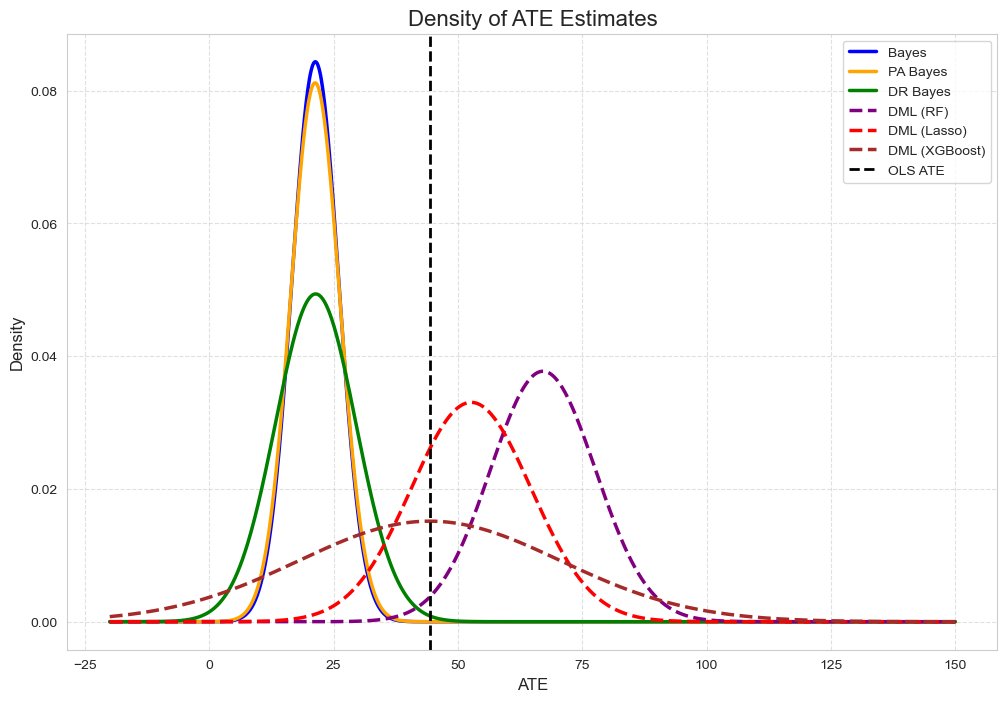

In [ ]:
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# Bayesian distributions as density curves
plt.plot(x_values, pdf_bayes, label='Bayes', color='blue', linewidth=2.5)
plt.plot(x_values, pdf_pa_bayes, label='PA Bayes', color='orange', linewidth=2.5)
plt.plot(x_values, pdf_dr_bayes, label='DR Bayes', color='green', linewidth=2.5)

# DML distributions as density curves
plt.plot(x_values, pdf_dml_rf, label='DML (RF)', color='purple', linestyle='--', linewidth=2.5)
plt.plot(x_values, pdf_dml_lasso, label='DML (Lasso)', color='red', linestyle='--', linewidth=2.5)
plt.plot(x_values, pdf_dml_xgb, label='DML (XGBoost)', color='brown', linestyle='--', linewidth=2.5)

# OLS ATE estimate as a vertical dashed line
plt.axvline(ate_or, color='black', linestyle='--', linewidth=2, label='OLS ATE')

plt.title('Density of ATE Estimates', fontsize=16)
plt.xlabel('ATE', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()
